# Imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
import logging
from typing import Tuple, Dict, Any, List, Union, Optional, Callable

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from metrics import calculate_metrics, metrics_to_tabular_string

random_state = 42

In [2]:
# logging levels: DEBUG, INFO, WARNING, ERROR, CRITICAL
# change to logging.WARNING to reduce verbosity
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# Introduction

TODO: Write something here!


# Notations

TODO: Maybe write something here!


# Environment

TODO: Write something here!


# Dataset

We'll be using the [Loan-Approval-Prediction-Dataset](https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset?resource=download) dataset from kaggle.

The loan approval dataset is a collection of financial records and associated information used to determine the eligibility of individuals or organizations for obtaining loans from a lending institution. It includes various factors such as:

1. cibil score: The customer's credit card score.
2. income: The customer's income.
3. employment status: If the customer is self employed or not.
4. loan term: The duration for which the loan is taken, expressed in years.
5. loan amount.
6. Residential/Commercial/Bank/Luxury assets value
7. loan status: If the loan is approved or not!

Before diving in, we'll explore the dataset to make it easier for the reader to get an overall intuition.


In [3]:
# Load the dataset
input_dir = "./kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv"
loan_original = pd.read_csv(input_dir)

loan_original.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


As we can see, there are strings in the data. We'll transform the dataset so we can apply learning algorithms on it.


In [4]:
# columns have weird spaces in names:
loan_original.columns = loan_original.columns.str.replace(" ", "")
loan_original[loan_original["loan_id"].duplicated(keep=False) == True].sort_values(
    ["loan_id"]
)
# remove the loan_id column
loan_ds = loan_original.drop(["loan_id"], axis=1)

# replace all spaces in loan_status and education and self_employed columns to ""
loan_ds["loan_status"] = loan_ds["loan_status"].str.replace(" ", "")
loan_ds["education"] = loan_ds["education"].str.replace(" ", "")
loan_ds["self_employed"] = loan_ds["self_employed"].str.replace(" ", "")

GRADUATE_STRING = loan_ds["education"].unique()[0]
NOT_GRADUATE_STRING = loan_ds["education"].unique()[1]
# make education column binary
loan_ds["education"] = loan_ds["education"].apply(
    lambda x: 1 if x == GRADUATE_STRING else 0
)

APPROVED_STRING = loan_ds["loan_status"].unique()[0]
REJECTED_STRING = loan_ds["loan_status"].unique()[1]
# make loan_status column binary
loan_ds["loan_status"] = loan_ds["loan_status"].apply(
    lambda x: 1 if x == APPROVED_STRING else 0
)

YES_STRING = loan_ds["self_employed"].unique()[1]
NO_STRING = loan_ds["self_employed"].unique()[0]
# make self_employed column binary
loan_ds["self_employed"] = loan_ds["self_employed"].apply(
    lambda x: 1 if x == YES_STRING else 0
)

loan_ds.describe(include="all")

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,2.498712,0.502225,0.503631,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,1.695910,0.500054,0.500045,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,0.000000,0.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,1.000000,0.000000,0.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,3.000000,1.000000,1.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,4.000000,1.000000,1.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,5.000000,1.000000,1.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


In [5]:
loan_ds["loan_status"].value_counts()

loan_status
1    2656
0    1613
Name: count, dtype: int64

In [6]:
loan_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   no_of_dependents          4269 non-null   int64
 1   education                 4269 non-null   int64
 2   self_employed             4269 non-null   int64
 3   income_annum              4269 non-null   int64
 4   loan_amount               4269 non-null   int64
 5   loan_term                 4269 non-null   int64
 6   cibil_score               4269 non-null   int64
 7   residential_assets_value  4269 non-null   int64
 8   commercial_assets_value   4269 non-null   int64
 9   luxury_assets_value       4269 non-null   int64
 10  bank_asset_value          4269 non-null   int64
 11  loan_status               4269 non-null   int64
dtypes: int64(12)
memory usage: 400.3 KB


By the data cleaning scans, we have confirmed:

1. There is no null value and duplicated value in this dataset.
2. `no_of_dependents`, `education`, `self_employed` and `loan_status` are categorical columns.
3. There are a total 4269 rows in this dataset, with 11 features and 1 target label.
4. There are 2656 data with an approved `loan_status`, which is about 62.2% compared to the "rejected" group. The dataset is slightly imbalanced but it is acceptable and we don't need to rebalance it.
5. Other columns are numerical.


## Dataset Explorations and Features Relations


We'll also show the correlation matrix as it's always useful to do so.


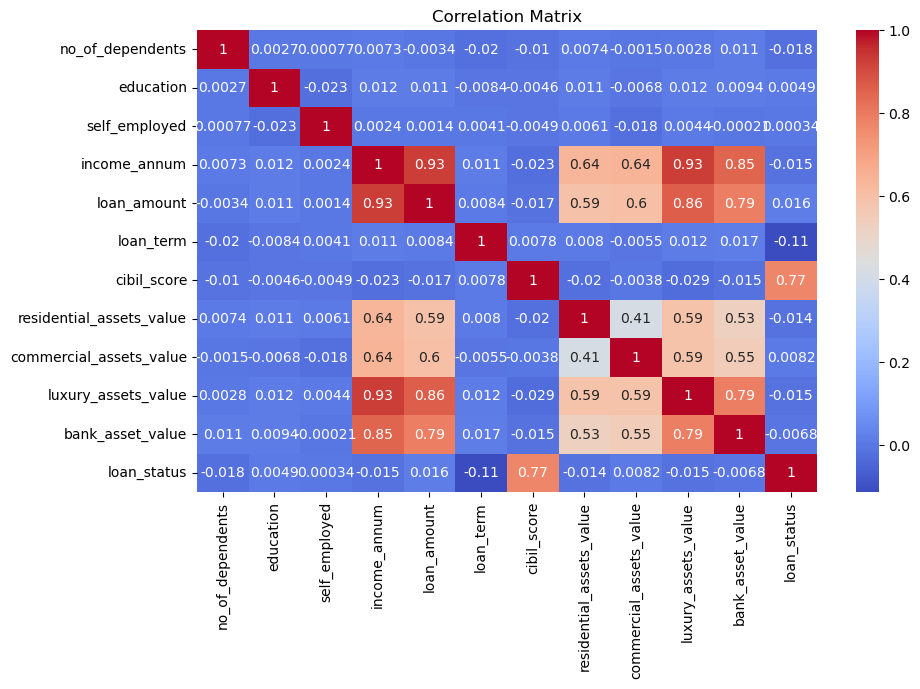

In [7]:
# corr and sns.heatmap
corr = loan_ds.corr()
plt.figure(figsize=(10, 6))

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

We can see that cibil_score and loan_status have a high correlation. This means that the cibil_score is a good predictor of loan_status.


We'll try and see if there're some "important" features that directly affect the loan_status (Approved/Rejected).


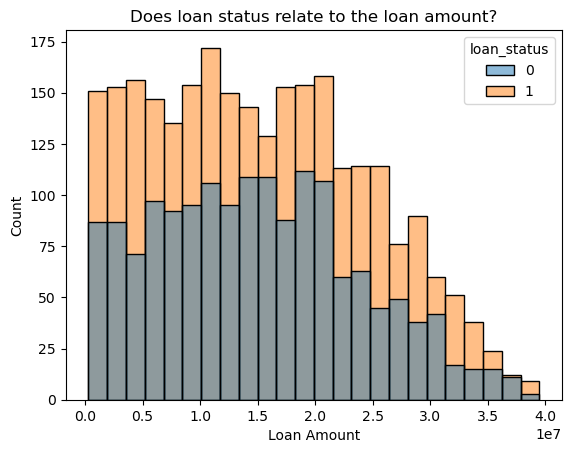

In [8]:
sns.histplot(loan_ds, x="loan_amount", hue="loan_status")
plt.title("Does loan status relate to the loan amount?")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

We can see that loan amount does not affect the loan status.


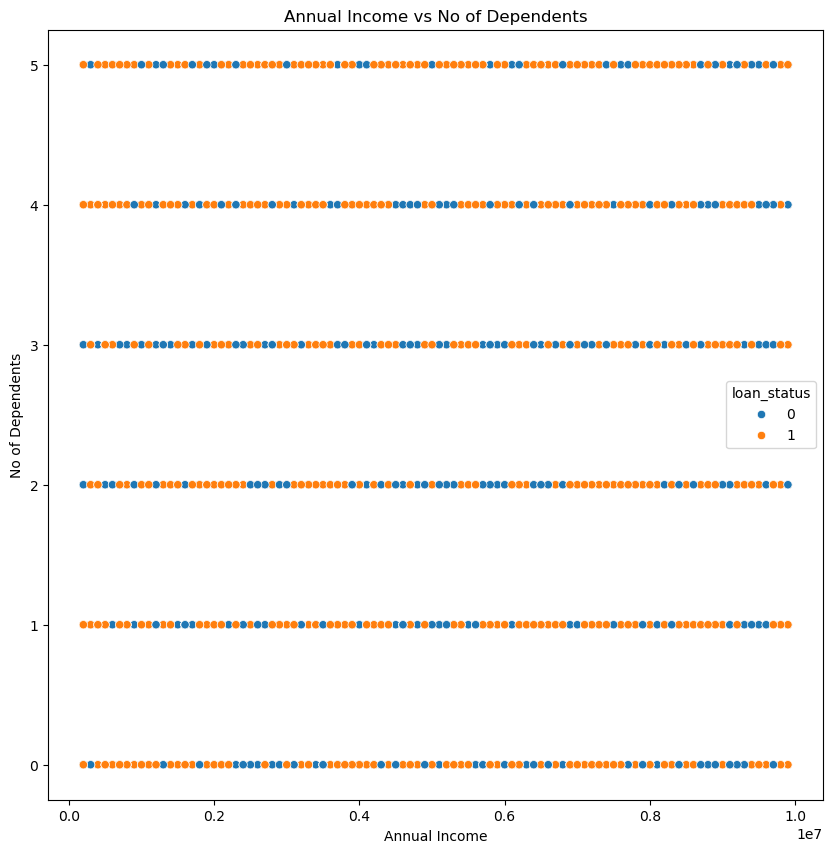

In [9]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=loan_ds, x="income_annum", y="no_of_dependents", hue="loan_status")
plt.title("Annual Income vs No of Dependents")
plt.xlabel("Annual Income")
plt.ylabel("No of Dependents")
plt.show()

We can see that num of dependents and annual income are not very effective in predicting loan status.


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


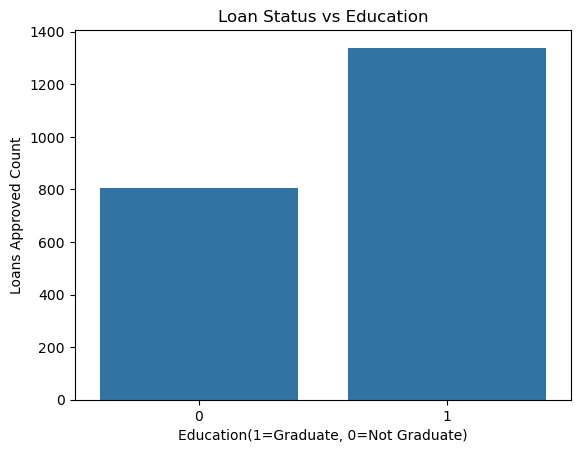

In [10]:
sns.countplot(data=loan_ds[loan_ds["education"] == 1], x="loan_status")
plt.title("Loan Status vs Education")
plt.xlabel("Education(1=Graduate, 0=Not Graduate)")
plt.ylabel("Loans Approved Count")
plt.show()

We can see the binary "Education" feature is somewhat informative to predict loan status.


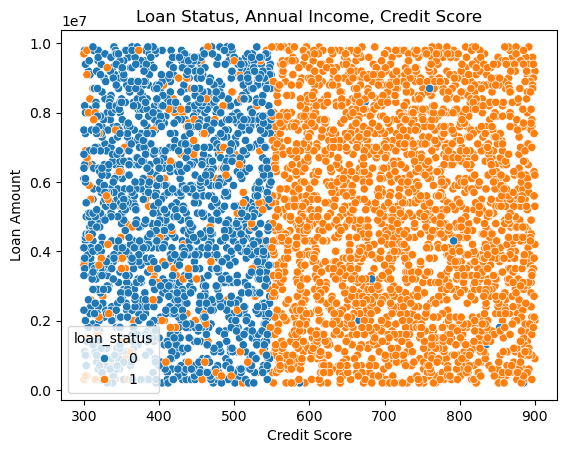

In [11]:
sns.scatterplot(
    x=loan_ds["cibil_score"], y=loan_ds["income_annum"], hue=loan_ds["loan_status"]
)
plt.title("Loan Status, Annual Income, Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

As can be seen, it seems that the data is kind of separable in terms of Credit Score as it appears there's some threshold. Let's try and implement a naive model that classifies the data according to this threshold.


In [12]:
def acc_for_column_threshold(
    df,
    feature_column,
    threshold,
    target_column,
    target_value_below_thresh,
    target_value_above_thresh,
):
    df_thresh = df.copy()
    # remove all cols except feature_column and target_column
    df_thresh = df_thresh[[feature_column, target_column]]
    # create new column with thresholded values
    df_thresh["thresh_pred"] = df_thresh[feature_column] >= threshold
    # change True/False to target values
    df_thresh["thresh_pred"] = df_thresh["thresh_pred"].replace(
        {True: target_value_above_thresh, False: target_value_below_thresh}
    )
    # calculate accuracy
    acc = accuracy_score(df_thresh[target_column], df_thresh["thresh_pred"])
    return df_thresh, acc

In [13]:
threshold = 540
df_thresh, acc = acc_for_column_threshold(
    loan_ds, "cibil_score", threshold, "loan_status", 0, 1
)
print(f"Accuracy for cibil_score threshold {threshold}: ", acc)

Accuracy for cibil_score threshold 540:  0.9355821035371281


We see that we get 0.93 accuracy, which is impressive since as we've mentioned the data is not imbalanced. If the data is imbalanaced say, 90% of loans are approved, a stupied classifier that always says 'Yes' would get 90% accuracy. But this is not our case.


## Training Different Models


In [14]:
# Basic parameters
default_batch_size = 64
default_test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Splitting the dataset into features and target
X = loan_ds.drop("loan_status", axis=1).values
y = loan_ds["loan_status"].values

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=default_test_size, random_state=random_state
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
class MLPModel(nn.Module):
    def __init__(self, input_size, layers_sizes):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer_size in enumerate(layers_sizes):
            if i == 0:
                self.layers.append(nn.Linear(input_size, layer_size))
            else:
                self.layers.append(nn.Linear(layers_sizes[i - 1], layer_size))
            self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.Linear(layers_sizes[-1], 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(x)


class Conv1DModel(nn.Module):
    def __init__(self, input_size, output_channels=16, kernel_size=3):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(1, output_channels, kernel_size=kernel_size, padding=1)
        self.fc1 = nn.Linear(
            output_channels * ((input_size + 2 * 1 - kernel_size) // 1 + 1), 64
        )
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Assuming x has shape (batch_size, input_size), we need to unsqueeze to (batch_size, 1, input_size) for Conv1D
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [16]:
# Helper functions to create a PyTorch dataset and dataloader
def prepare_data(
    loan_ds,
    test_size=default_test_size,
    random_state=random_state,
    batch_size=default_batch_size,
):
    # Splitting the dataset into features and target
    X = loan_ds.drop("loan_status", axis=1).values
    y = loan_ds["loan_status"].values

    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Converting to PyTorch tensors
    X_torch_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_torch_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

    y_torch_train = torch.tensor(y_train, dtype=torch.float32)
    y_torch_test = torch.tensor(y_test, dtype=torch.float32)

    # Creating datasets and dataloaders
    train_dataset = TensorDataset(X_torch_train_scaled, y_torch_train)
    test_dataset = TensorDataset(X_torch_test_scaled, y_torch_test)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False)

    return X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader


# Helper function that gets the names of the models and their corresponding PyTorch models


"""
This function generates some of the models we will work with.
MLP in different sizes, the layers sizes shown in the list.
And a conv1D model, which is like a convnet in 2D, but in 1D.
"""


def get_names_to_new_models(input_size):
    return {
        "Small MLP": MLPModel(input_size, [32, 16]),
        "Medium MLP": MLPModel(input_size, [64, 32, 16]),
        "Large MLP": MLPModel(input_size, [128, 64, 32, 16]),
        "Conv1D": Conv1DModel(input_size),  # Conv1D model
    }


# Helper function that trains and evaluates a PyTorch model


def train_and_evaluate_pytorch_model(
    threshold, model, model_name, train_loader, test_loader, epochs=100, lr=0.001
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Training loop
    model.train()
    for epoch in tqdm.tqdm(range(epochs), desc=f"Training {model_name}"):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            all_labels.extend(labels.numpy())
            all_outputs.extend(outputs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    metrics = calculate_metrics(all_labels, all_outputs, threshold)

    return {
        "model": model,
        "model_name": model_name,
        "metrics": metrics,
    }


# Helper function that compares the results of different models
# According to the metrics given in metrics parameter
def compare_torch_models(model_results, metrics):
    model_metrics = {}
    model_names = {}
    for metric in metrics:
        model_metrics[metric] = [result["metrics"][metric]
                                 for result in model_results]
        model_names[metric] = [result["model_name"]
                               for result in model_results]

    # Plotting
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(len(metrics), 1, figsize=(14, 12))

    colors = ["orange", "blue", "green", "red"]

    for i, metric in enumerate(metrics):
        x = np.arange(len(model_names[metric]))  # the label locations
        rects = ax[i].bar(
            x, model_metrics[metric], width, label=metric, color=colors[i % len(
                colors)]
        )
        # Show the number on the bars
        for rect in rects:
            height = rect.get_height()
            ax[i].annotate(
                f"{height:.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )
        ax[i].set_ylabel("Scores")
        ax[i].set_title(f"Model {metric} Comparison")
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(model_names[metric])
        ax[i].legend()

    fig.tight_layout()
    plt.show()

Get the results of the different models using the helper functions above.


In [17]:
X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader = prepare_data(
    loan_ds
)
input_size = X_torch_train_scaled.shape[1]
names_to_models = get_names_to_new_models(input_size)
threshold = 0.5

torch_models_results = []
for model_name, model in names_to_models.items():
    model = model.to(device)
    result = train_and_evaluate_pytorch_model(
        threshold, model, model_name, train_loader, test_loader
    )
    torch_models_results.append(result)

Training Conv1D: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


Compare the different torch models in terms of accuracy and f1_score.


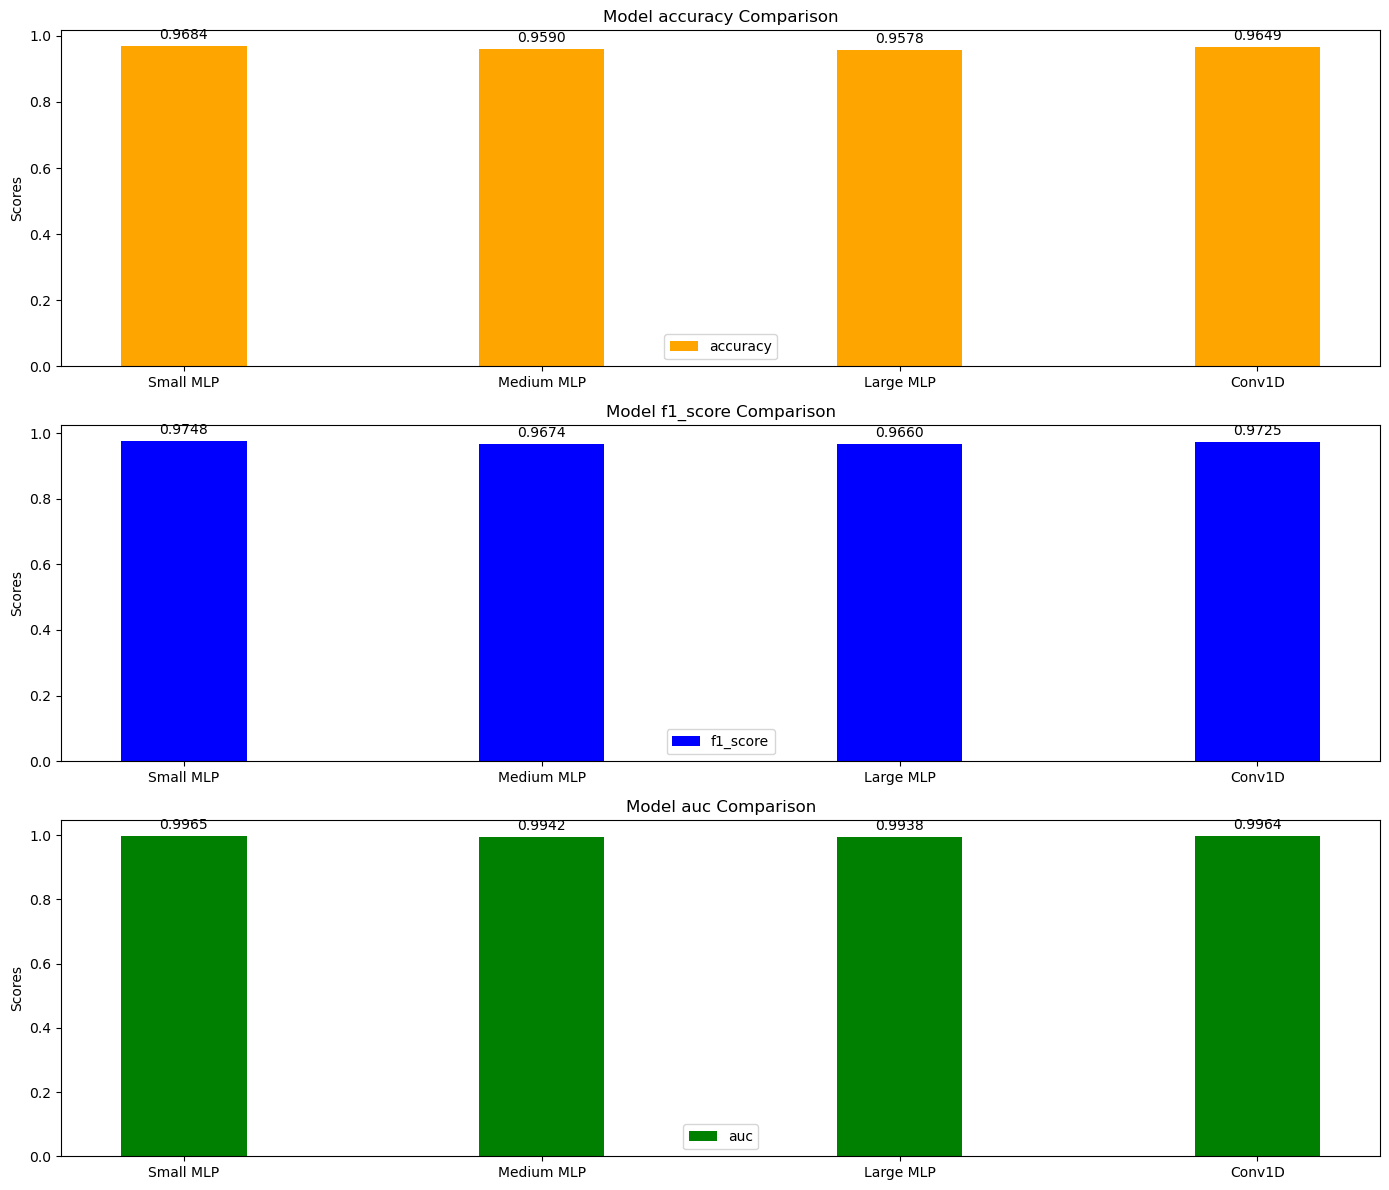

In [18]:
compare_torch_models(torch_models_results, ["accuracy", "f1_score", "auc"])

It's evident that all models get very good results for the dataset without strategies etc. LET THE CHALLENGE BEGIN!


# Simulation with Gradients


In this experiment, we want to see how the importance of the features change as the users make strategies in those features.

As we saw in the plots so far, the problem is pretty linear (using cibil_score threshold gave us 93%), meaning, that calculating the average gradient of the model score w.r.t. the features, will give us a vector that represents in a good way the importance of each feature to the score.

Positive gradient -> increase the feature in average will increase the score.

Negative -> vice verse.

TODO - Follow all project pdf that says write hypotheses... and do all


## Gradients


In [19]:
# Helper function that takes: model, loan_ds, row_index
# Calculates the gradient magnitude of the row in row_index in the dataset
def calculate_gradient_magnitude(model, loan_ds, row_index):
    row = loan_ds.iloc[row_index].copy()
    X = row.drop("loan_status").values
    X = scaler.transform(X.reshape(1, -1))
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y_pred = model(X).item()
    X.requires_grad = True
    y_pred = model(X)
    y_pred.backward()
    grads = X.grad.cpu().numpy().flatten()
    return grads, row


def calculate_and_plot_gradients(
    model, model_name, loan_ds, plot_first_num=5, metrics=None, plot_mean=True
):
    """
    Calculates gradients for each row in the dataset, plots the gradient magnitudes
    for the first 'plot_first_num' rows, and finally plots the mean gradient magnitude.
    Args:
    - model: The neural network model to use.
    - model_name: The name of the model.
    - loan_ds: The dataset.
    - plot_first_num: Number of initial gradients to plot individually.
    - metrics: The metrics dictionary for the model, if None we will not show it.
    - plot_mean: Whether to plot the mean gradient magnitude.

    Returns:
    - mean_grads: Vector of mean gradients across all features.
    """
    loan_ds_copy = loan_ds.copy()
    features = loan_ds_copy.iloc[0].drop("loan_status").index

    # Initialize variables
    rows_to_calc_grad = loan_ds_copy.index
    all_grads = []

    # Calculate gradients for each row
    for loop_index, row_to_calc_grad in enumerate(rows_to_calc_grad):
        grads, row = calculate_gradient_magnitude(
            model, loan_ds_copy, row_to_calc_grad)
        all_grads.append(grads)

        # Plot for the first 'plot_first_num' rows
        if loop_index < plot_first_num:
            logging.debug(f"Row: {row_to_calc_grad} with features:\n {row}")
            logging.debug(f"And Grads: {grads}")
            logging.debug("\n=================================\n")
            plt.figure(figsize=(10, 6))
            sns.barplot(
                x=grads, y=features, hue=features, palette="viridis", legend=False
            )
            plt.xlabel("Gradient Abs values")
            plt.ylabel("Feature")
            plt.title(
                f"Feature Importance for model {model_name} by Gradient, of row: {row_to_calc_grad}"
            )
            plt.show()

    # Calculate mean of all gradients
    mean_grads = np.mean(all_grads, axis=0)

    if plot_mean:
        # Plot mean gradients
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(
            x=mean_grads, y=features, hue=features, palette="viridis", legend=False
        )
        plt.xlabel("Gradient Mean values")
        plt.ylabel("Feature")
        title = f"Feature Importance by Gradient *Mean* for model: {model_name}"
        if metrics is not None:
            title += " | Metrics: \n"
            for key, value in metrics.items():
                if np.isscalar(value):
                    title += f"{key}: {value:.2f}, "
                else:
                    # makes image huge...
                    # title += f"{key}: {value}, "
                    pass
        logging.debug(f"Title is: {title}")
        plt.title(title)

        # Customize plot appearance
        ax.set_facecolor("#303030")  # Dark grey background
        plt.gcf().set_facecolor("#303030")  # Set figure background color
        ax.xaxis.label.set_color("white")
        ax.yaxis.label.set_color("white")
        ax.title.set_color("white")
        ax.tick_params(axis="x", colors="white")
        ax.tick_params(axis="y", colors="white")
        ax.grid(axis="x")
        for spine in ax.spines.values():
            spine.set_edgecolor("white")
        plt.show()

    return mean_grads

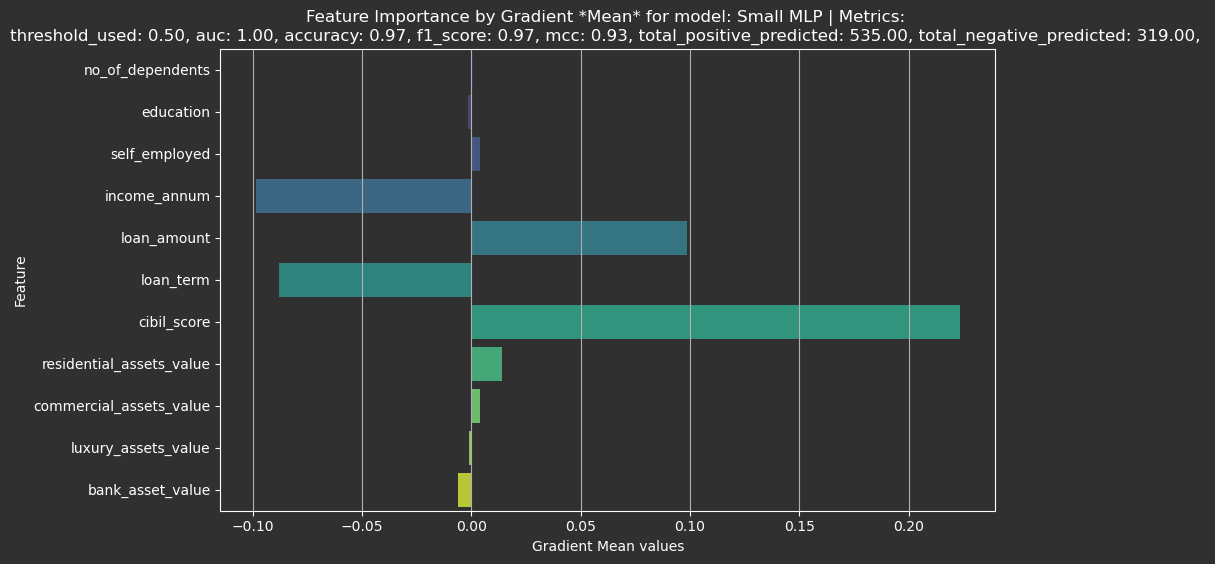

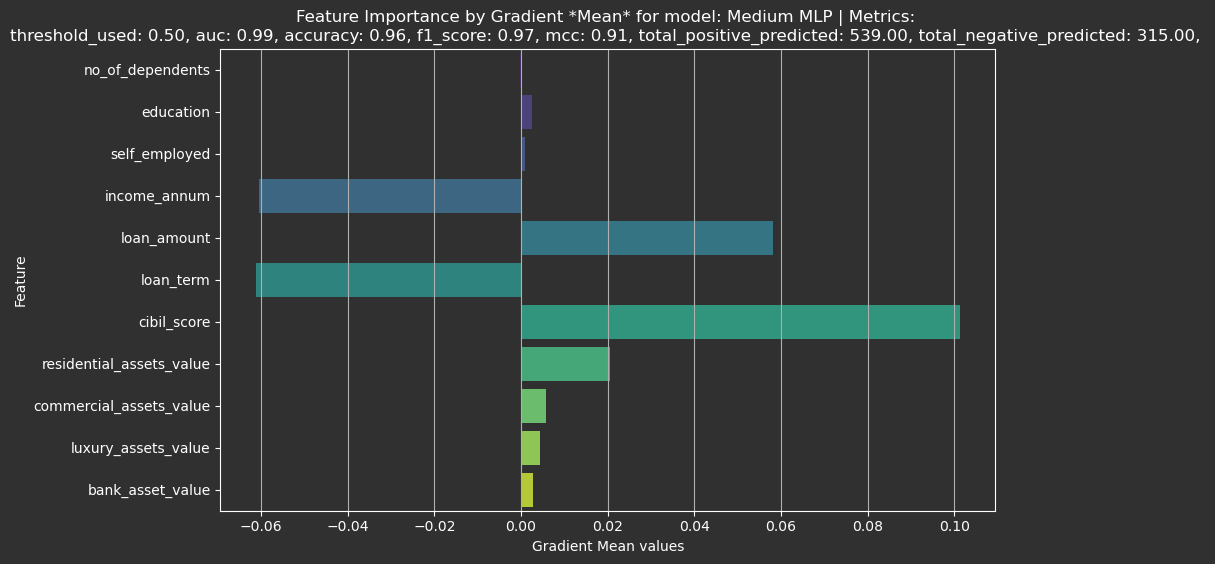

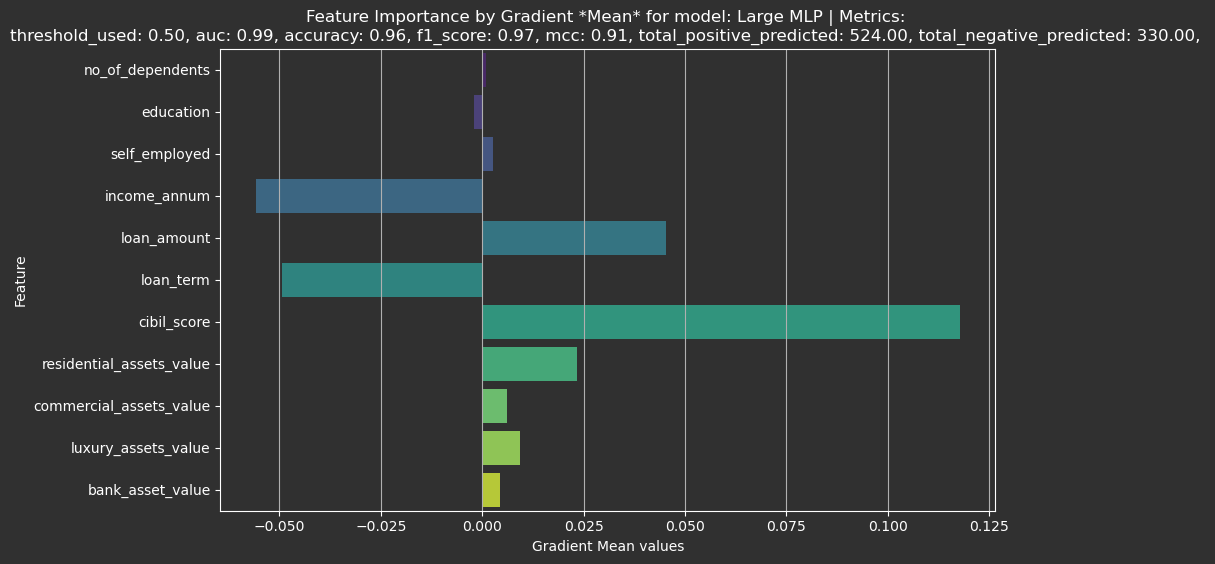

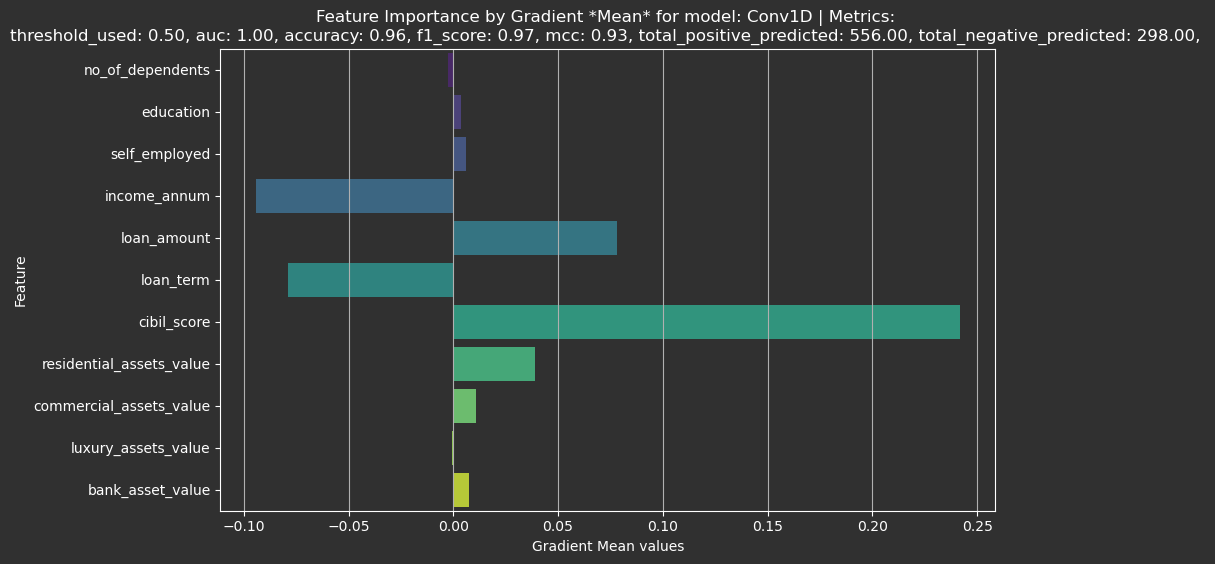

In [20]:
for model_result in torch_models_results:
    model_name = model_result["model_name"]
    model = model_result["model"]
    metrics = model_result["metrics"]
    mean_grads = calculate_and_plot_gradients(
        model, model_name, loan_ds, plot_first_num=0, metrics=metrics
    )

As expected, the cibil_score is significantly informative across all models. The average gradient of the score with respect to this feature is very high, indicating that increasing the cibil_score aligns with the direction of the gradient, which in turn enhances the score, as we saw in the cibil_score plot.

Similarly, reducing the loan_term leads to a higher score(in average), as the average gradient with respect to this feature is negative.

Additionally, as models increase in size, they begin to consider additional features. This is evidenced by the mean gradient vector becoming more balanced in terms of absolute values across different features, suggesting that larger models utilize a broader range of features.

This expansion in feature usage by larger models can be explained by their improved ability to discern the relationships between less informative features and the loan_status compared to smaller models, thereby incorporating these lower-information features into their assessments.


## Strategic Users


Now, as we've made ourselves familiar with the data and how important in average each feature is, we'll try and utilize this information to create an environment with strategic users.


In [21]:
def create_strategists_loan_ds(
    loan_ds_to_change: pd.DataFrame,
    range_strategists_act: Tuple[float, float],
    features_to_change: Dict[str, Tuple[Tuple[float, float], float]],
    model_to_fool: nn.Module,
    trainable_version=True,  # if false will have extra columns that not need for train,
    # but can make it trainable again with make_strategists_loan_ds_trainable() function
):
    """
    Calculates gradients for each row in the dataset, plots the gradient magnitudes
    for the first 'plot_first_num' rows, and finally plots the mean gradient magnitude.
    Args:
    - loan_ds_to_change: loan dataset to change
    - range_strategists_act: The score range of which users are chosen to be strategic. i.e. (0.3, threshold)
    - features_to_change: feature -> (range to sample the change, sign[add or sub]) :
        A dictionary of features to change, with a range to choose from and a sign
    - model_to_fool: The model to try and fool

    Returns:
    - strategists_loan_ds: loan dataset after performing strategies.
    - strategists_rows: The rows of users that performed strategy
    """
    strategists_loan_ds = loan_ds_to_change.copy()
    for index, row in strategists_loan_ds.iterrows():
        X = row.drop("loan_status").values
        X = scaler.transform(X.reshape(1, -1))
        X = torch.tensor(X, dtype=torch.float32).to(device)
        if trainable_version:
            y_pred = model_to_fool(X).item()
            # add the y_pred as score column
            strategists_loan_ds.at[index, "score_before_strategy"] = y_pred
        if range_strategists_act[0] <= y_pred and y_pred <= range_strategists_act[1]:
            # set the using_strategy column to True
            strategists_loan_ds.at[index, "using_strategy"] = 1
            for feature_name, feature_info in features_to_change.items():
                # feature_info is a tuple of (range, sign)
                feature_range_low = feature_info[0][0]
                feature_range_high = feature_info[0][1]
                feature_sign = feature_info[1]
                value_to_add = np.random.uniform(
                    feature_range_low, feature_range_high)
                strategists_loan_ds.at[index, feature_name] += (
                    value_to_add * feature_sign
                )
        else:
            strategists_loan_ds.at[index, "using_strategy"] = 0
    strategists_rows = strategists_loan_ds[strategists_loan_ds["using_strategy"] == 1]
    if trainable_version:
        # Drop the unwanted columns
        strategists_loan_ds.drop(
            ["using_strategy", "score_before_strategy"], axis=1, inplace=True
        )

    return strategists_loan_ds, strategists_rows


def make_strategists_loan_ds_trainable(strategists_loan_ds):
    """if instantiated with trainable_version=False, will have extra columns
    that not need for train, so use this function to make it trainable again."""
    strategists_loan_ds_trainable = strategists_loan_ds.copy()
    # remove the columns
    strategists_loan_ds_trainable.drop(
        ["using_strategy", "score_before_strategy"], axis=1, inplace=True
    )
    return strategists_loan_ds_trainable

## Simulation


Now, we'll utilize the above function to implement an initial dynamic simulation.

The simulation would have T timestamps, starting with the initial loan dataset (loan_ds).

At each timestamp, the process involves calculating the mean gradients of features, selecting the top K features with the highest absolute mean gradient (as these have the most significant impact on the model), and recording these in a 'features_to_change' list.

The selected features are then added (or substracted, depends on the gradient sign)a value sampled uniformly within the range of:

[feature current mean * strategy magnitude, feature current mean * (strategy magnitude + 0.1)].


In [22]:
def run_first_simulation(
    T: int,
    K: int,
    MODEL: str,
    strategy_magnitude: float,
    range_strategists_act: Tuple[float, float],
    threshold=0.5,
    print_mean_grads_every=5,
):
    """
    Runs a simulation with T timestamps, K top features to change, and a strategy magnitude.

    Args:
    - T: The number of timestamps to run the simulation.
    - K: The number of top features to change.
    - MODEL: The model to use.
    - strategy_magnitude: The magnitude is a ratio of the mean feature value to change.
    - range_strategists_act: The score range of which users are chosen to be strategic. i.e. (0.3, threshold)
    """

    strategists_loan_ds_dict = {}
    strategists_rows_dict = {}
    results_dict = {}

    names_to_models = get_names_to_new_models(input_size)
    for model_name, _ in names_to_models.items():
        strategists_loan_ds_dict[model_name] = loan_ds.copy()

    for t in range(T):
        logging.info(f"Timestamp {t}:")
        for model_name, model in names_to_models.items():
            if model_name != MODEL:  # Get rid off this line to run on all models
                continue

            model = model.to(device)
            # Prepare the data
            X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader = (
                prepare_data(strategists_loan_ds_dict[model_name])
            )
            # Train and evaluate
            results_dict[model_name] = train_and_evaluate_pytorch_model(
                threshold, model, model_name, train_loader, test_loader
            )
            metrics = results_dict[model_name]["metrics"]
            # logging.debug(metrics)
            # calculate and plot gradients

            mean_grads = calculate_and_plot_gradients(
                model,
                model_name,
                strategists_loan_ds_dict[model_name],
                plot_first_num=0,
                metrics=metrics,
                plot_mean=(t % print_mean_grads_every == 0),
            )

            # Get the top K features
            top_k_indices = np.argsort(np.abs(mean_grads))[::-1][:K]
            top_k_features = strategists_loan_ds_dict[model_name].columns[top_k_indices]
            # logging.info(
            #     f"Top {K} features for model {model_name}: {top_k_features}")

            # Create features_to_change dictionary
            features_to_change = {}
            for feature, index in zip(top_k_features, top_k_indices):
                # logging.info(
                #     f"Mean gradient for {feature}: {mean_grads[index]}")
                mean_feature_value = strategists_loan_ds_dict[model_name][
                    feature
                ].mean()
                # features_to_change is a dictionary of feature: (range, gradient)
                range_to_sample_change_from = (
                    # Here we need to change to be mul by features_strategy_magnitude[feature]
                    mean_feature_value * strategy_magnitude,
                    mean_feature_value
                    # here take like prev line + 0.1
                    * (strategy_magnitude + 0.1),
                )
                features_to_change[feature] = (
                    range_to_sample_change_from,
                    np.sign(mean_grads[index]),
                )

            # logging.info(
            #     f"Features to change for model {model_name}: {features_to_change}"
            # )

            # Create strategists_loan_ds
            strategists_loan_ds_dict[model_name], strategists_rows_dict[model_name] = (
                create_strategists_loan_ds(
                    strategists_loan_ds_dict[model_name],
                    range_strategists_act,
                    features_to_change,
                    model,
                )
            )

            # logging.info(
            #     f"Model {model_name} created {len(strategists_rows_dict[model_name])} strategists."
            # )

    # Show mean gradients for the models chosen
    for model_result in results_dict.values():
        if model_result["model_name"] != MODEL:
            continue
        model_name = model_result["model_name"]
        model = model_result["model"]
        metrics = model_result["metrics"]
        calculate_and_plot_gradients(
            model,
            model_name,
            strategists_loan_ds_dict[model_name],
            plot_first_num=0,
            metrics=metrics,
        )

For simulations, we are using Large MLP only, to reduce simulations time,
and as we already observed - different models behave pretty similar.


In this simulation we expect to observe several things when we change: strategy_magnitude, range_strategists_act.
This in fact, will be our simulation that proves/disproves the following hypothesis:

<b>The importance of a feature will decrease if users apply strategy to it and may become uniform(across all features) if strategies are used aggressively.</b>

When the strategy_magnitude is set to 0.6 and the range_strategists_act is within the range of 0.0 to a specified threshold,

the model is likely to quickly converge to a performance that appears random. This is because strategies pile up in the features, and the features becomes not informative.

Consequently, the mean gradients will undergo drastic changes and are likely to become more uniform compared to their initial state, as the features become less and less important.

Our observations indicate that a T value of 10 is sufficient.


INFO: Timestamp 0:
Training Large MLP:   0%|          | 0/100 [00:00<?, ?it/s]

Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


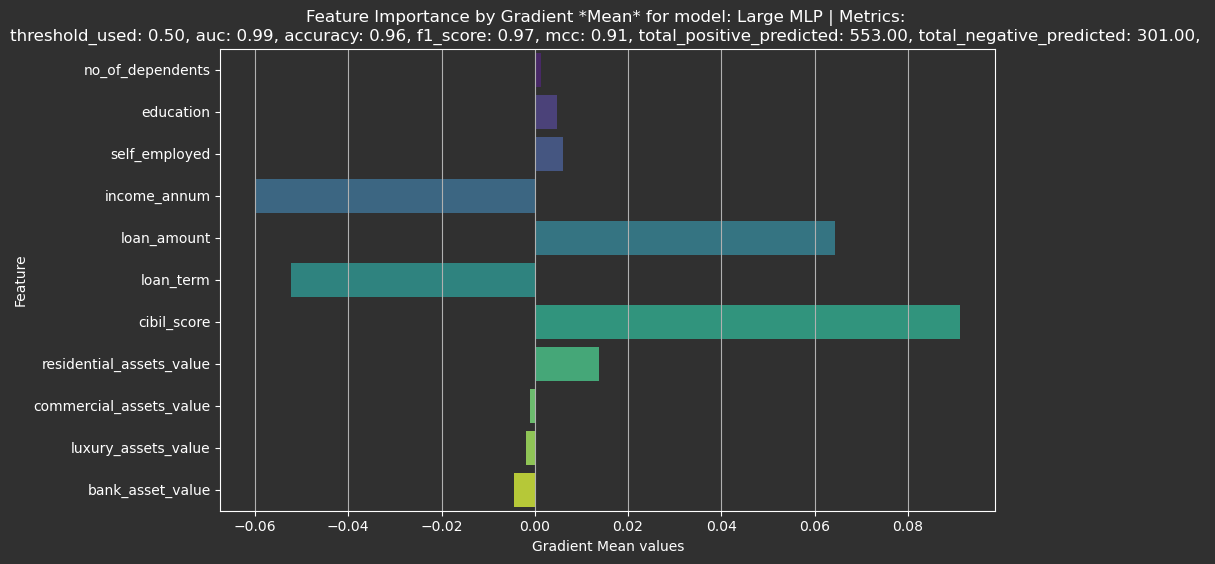

/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '785.1777653545473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += (
INFO: Timestamp 1:
Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 14.86it/s]
/tmp/ipykernel_105940/964990008.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[ind

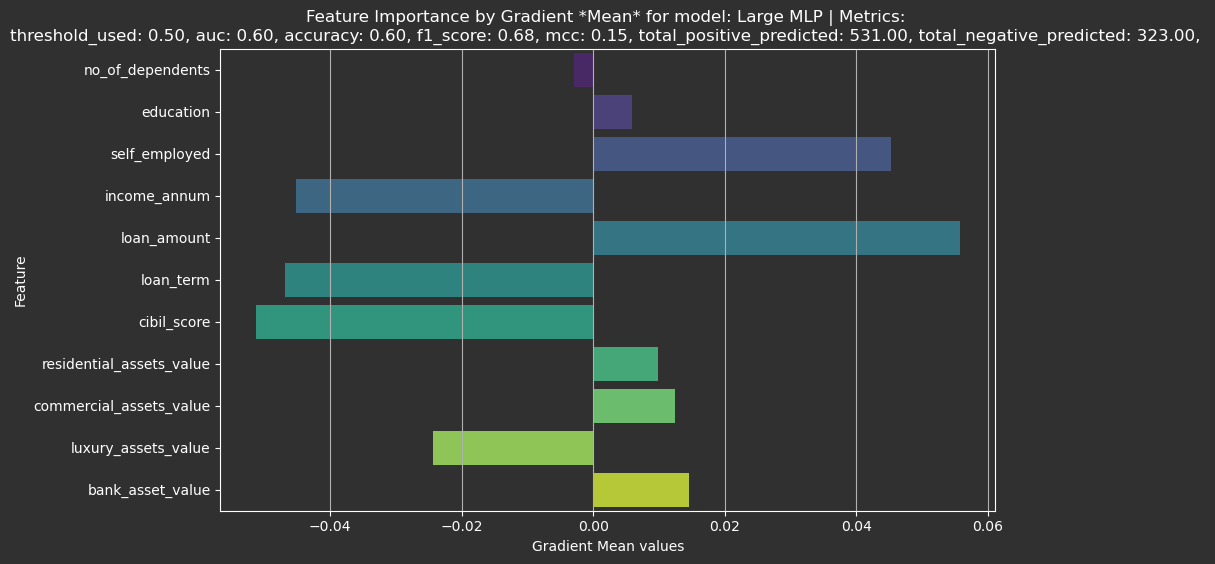

/tmp/ipykernel_105940/964990008.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(True)
INFO: Timestamp 6:
Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0257679474323593' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_l

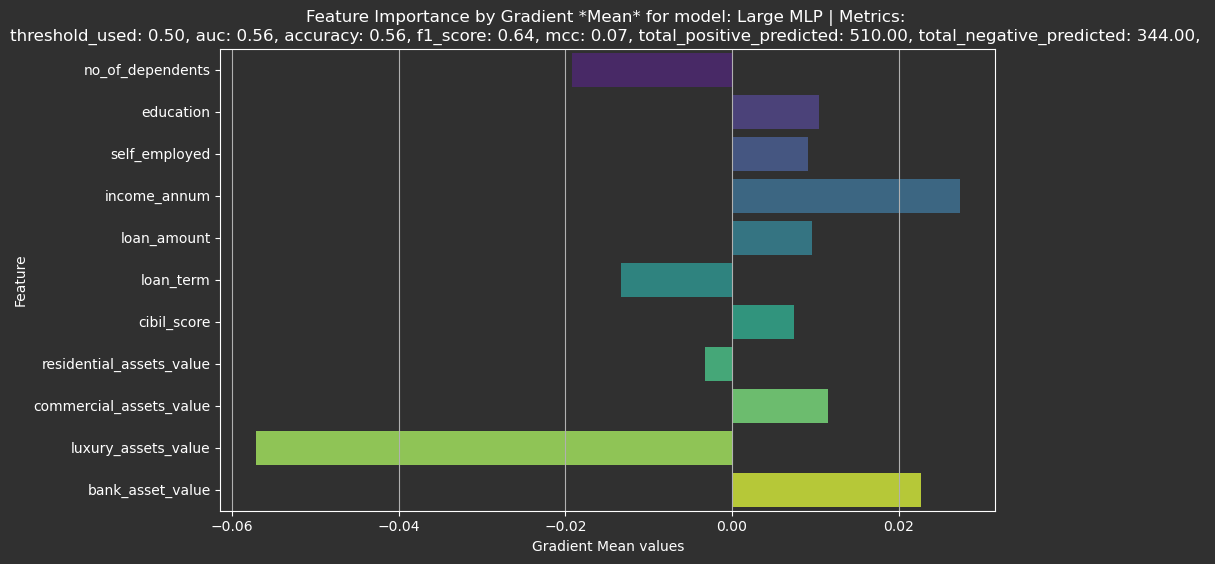

In [23]:
run_first_simulation(
    T=10,
    K=1,
    MODEL="Large MLP",
    strategy_magnitude=0.6,
    range_strategists_act=(0.0, threshold),
    print_mean_grads_every=5,
)

As we can see in the graphs above, the model started with reasonable gradients that puts importance on cibil_score, and after 5 epochs - the loan term became the most important feature, and after another 5 epochs everything changed again,
which confirms our hypotheses that the gradient will be not informative anymore.

Also, we can see that after 5 epochs we have 0.61 acc, and after 10 we have 0.56, which confirms our hypotheses that model will become pretty random (almost 50% acc).


## The "left people" experiment:


In this experiment, we will define that strategists act if they get model score
in the range [0.2, 0.5].

Therefore, we expect that after some timestamps,

the strategists that was initially in that range will get above the threshold and classified as ones that can take a loan,
but those under 0.2 will probably never use strategy,

so the model will be correct


INFO: Timestamp 0:
Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 15.92it/s]


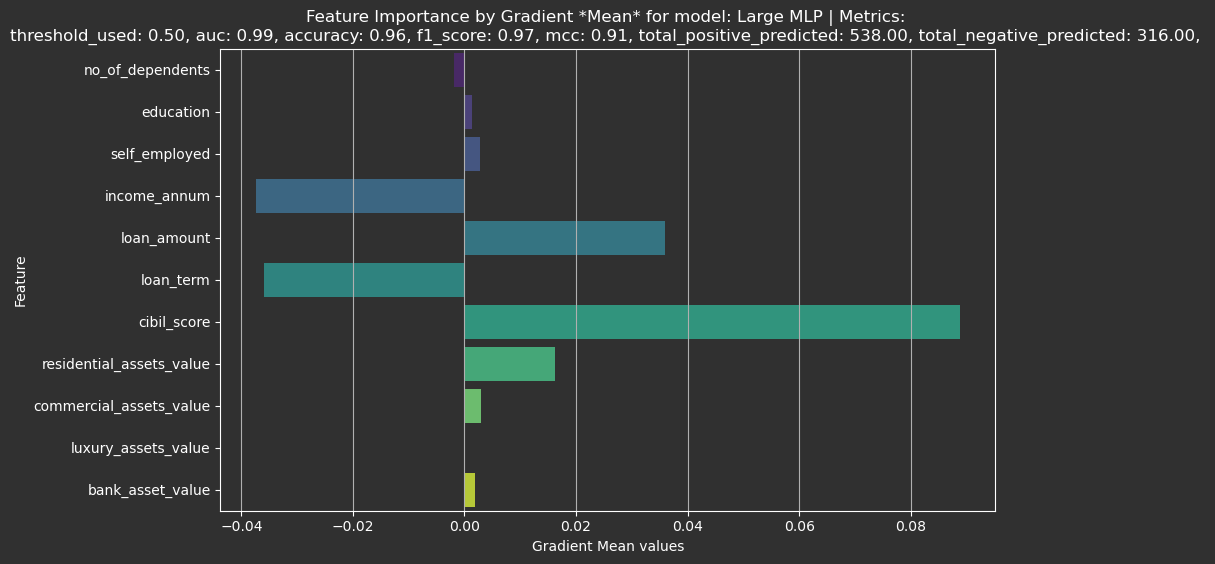

/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1364.3109160491636' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += (
INFO: Timestamp 1:
Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 15.71it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[i

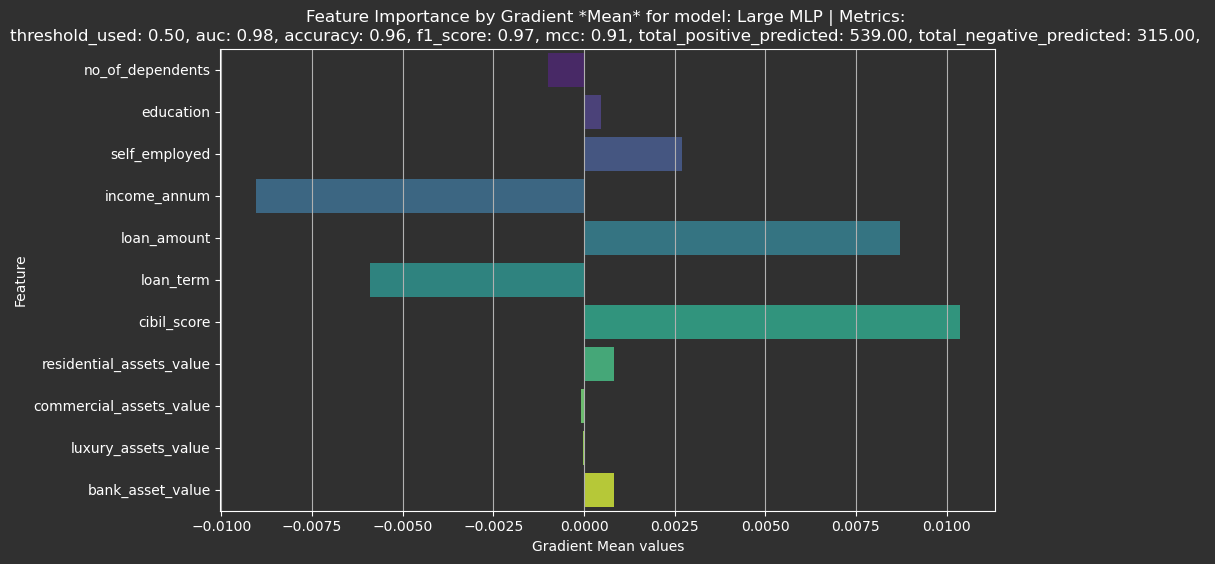

/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
INFO: Timestamp 6:
Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2255775.2476251954' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists

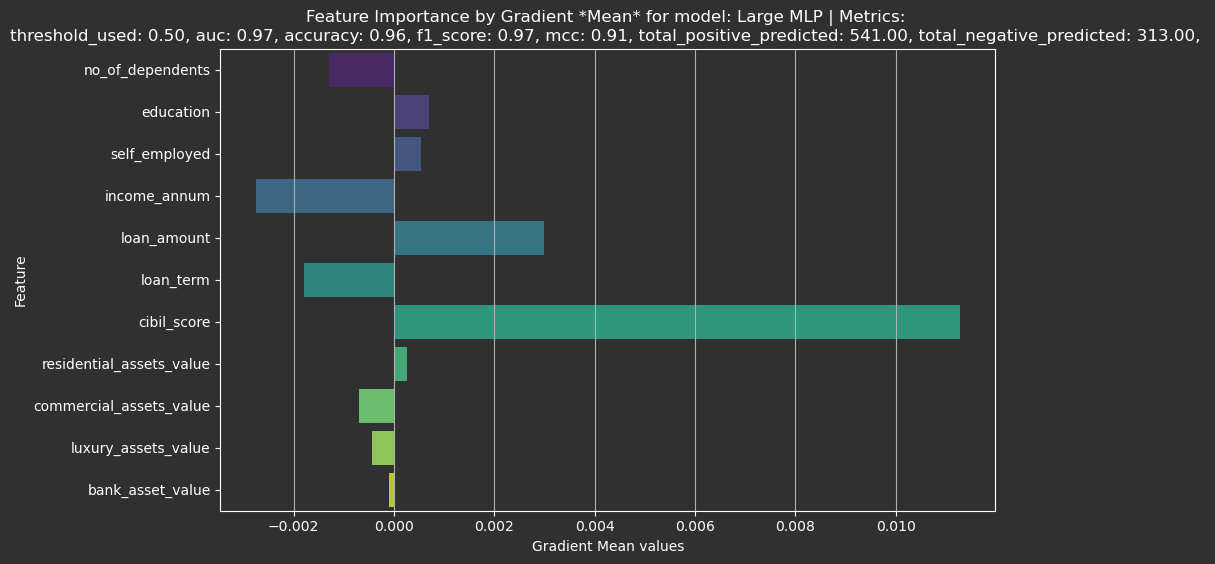

In [24]:
threshold = 0.5
run_first_simulation(
    T=10,
    K=1,
    MODEL="Large MLP",
    strategy_magnitude=0.9,
    range_strategists_act=(max(0, threshold - 0.3), threshold),
    print_mean_grads_every=5,
)

That's surprising. Even though we define strategists to act in [0.2, 0.5]
it seems the model performance remained pretty stable.

That's because most of the people that are below the threshold probably are
much below 0.2 score, therefore there are not a lot of strategists and therefore acc remain stable and the gradient vector shows good results (gives cibil_score the most importance)

### Let's check this hypotheses and define a new range, [0.01, 0.5] for strategists to act:


INFO: Timestamp 0:
Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 15.44it/s]


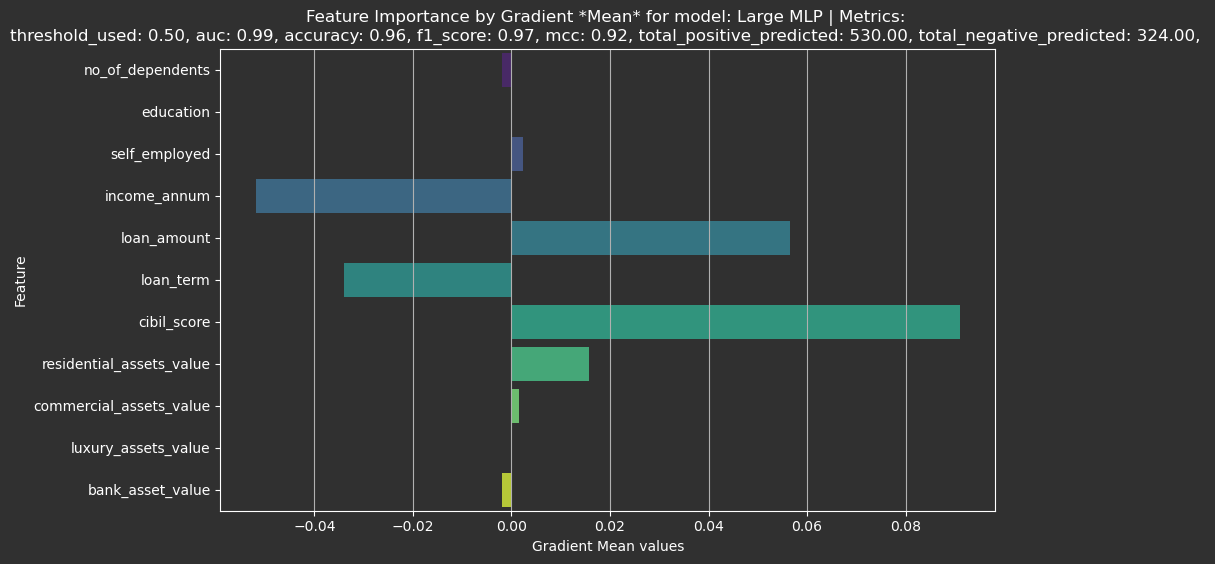

/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1265.3883135411177' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += (
INFO: Timestamp 1:
Training Large MLP: 100%|██████████| 100/100 [00:05<00:00, 16.82it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[i

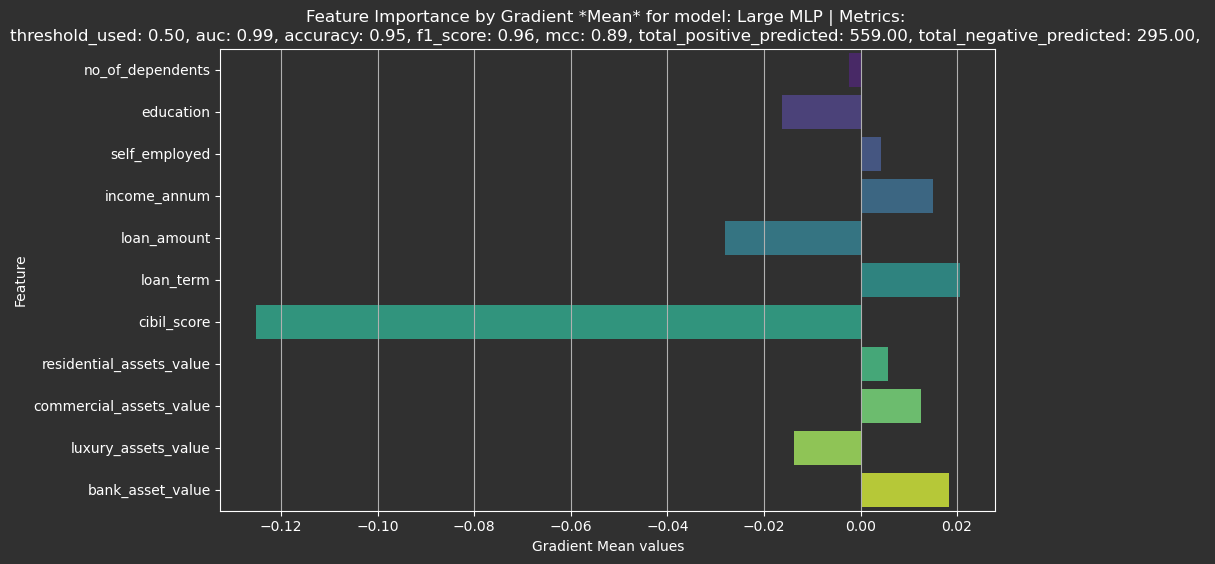

/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
INFO: Timestamp 6:
Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 15.23it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
INFO: Timestamp 7:
Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 15.69it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible w

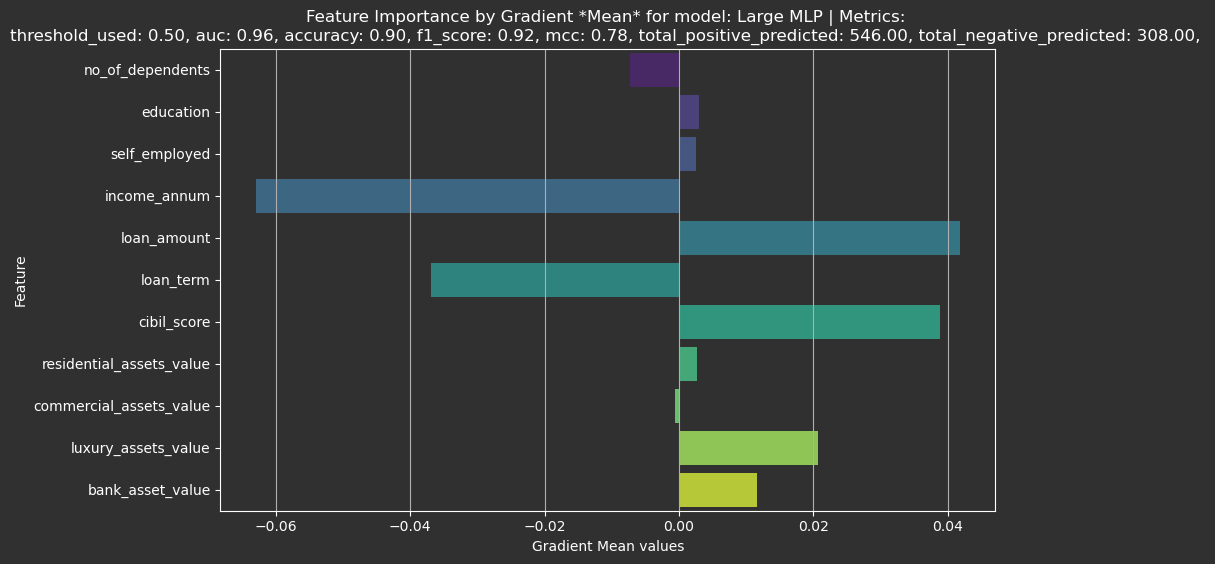

In [25]:
threshold = 0.5
run_first_simulation(
    T=10,
    K=1,
    MODEL="Large MLP",
    strategy_magnitude=0.9,
    range_strategists_act=(max(0, threshold - 0.49), threshold),
    print_mean_grads_every=5,
)

Now we got the results we were expecting for.
We can see the model accuracy harmed but not so much, it ended with 0.85 acc, because all people with score < 0.01 remained untouched and therefore the model is correct about them.

This simulation really resembles the real life.

Imagine a bank that wants to give loans to "good loaners", the people that are close to get a loan, meaning, get a score below 0.5 but above 0.01 for example, will change each time the feature that is the most important for the bank.

In our case - this feature is the feature with the highest absolute gradient when calculated with the bank's model.

It resembles the real life where people talk with each other and bank advisors and know what's the most important feature for the bank, and change their feature accordingly, just as we did in this simulation.

So we can conclude that in this dynamic system, people near the threshold will eventually succeed get the loan if they keep "satisfy" the bank with the important feature, and accumulate those changes over time, but those who are not using strategy all the time will remain below the threshold and the model keep classify them correctly, and therefore the model acc will be just partially harmed.


# Section 2: Simulation with Weights


## Feature Strategy Vector


In this section, we'll focus on a more realistic scenario. In contrary to the previous part, we'll not choose strategic features according to their mean gradient.

We'll choose features according to what realistically can be modified and to what extent.

In our simulation the assumption is that the bankers evaluate how much people can change each feature (their assumption is a scalar, that is used to sample the change in feature that the strategy cause. But they don't know how the strategic sample the change, only the "reliability" of each feature as scalar) and they're right in their assumption.

Therefore, for each feature, we'll attach a reliability score in the range of [0,1] (and the strategic magnitude is 1-reliability)

which would used to calculate how much the user can add or subtract to the feature.

To the score we'll also attach a sign 1 or -1 to indicate if it's logical for the user to add to the value or reduce from it. we will choose the 1 or minus 1 according to the gradient vectors calculated at the begining, for example,

We will give cibil_score a +1 sign cause gradient is positive, and -1 to income_annum cause it's negative, and people might want to reduce it (assuming the problem is pretty linear).

For example, people know that bank values cibil score, so they want to magnify this feature, so the reliability of this feature will be low.

We will train 2 or 3 models(now always train informed model) in each simulation:

1. model_for_initial_scores - model that train regular, and according to the scores
   it gives to users, we define who will be the strategists - those who got score(that given with this model) between 0 and 0.5 for example
2. baseline model - model that trains on the dataset after the strategists act. We can compare its performance to the previous model to see how much the strategists harmed the data, and if we train the informed model we can compare with it too.
3. informed model - model that utilizes the feature strategy vector to perform better. That's the bank that evaluates the reliability of features to improve the model. There are a lot of ideas how to utilize the features reliabilities, we will present some and implement some.

Our goal is to help the bank utilize the reliability to enhace the model when comparing to the same model that did not utilized this information.

We'll start by defining the feature strategy vector.


In [167]:
from enum import Enum


def get_large_mlp_model(input_size):
    return get_names_to_new_models(input_size)["Large MLP"].to(device)


def create_features_to_change_from_strategy_vector(
    ds: pd.DataFrame, feature_strategy_vector: Dict[str, Dict[str, float]]
) -> Dict[str, Tuple[Tuple[float, float], float]]:
    """
    Creates a dictionary of features to change from the feature_strategy_vector.

    Args:
    - ds: The loan dataset.
    - feature_strategy_vector: The feature strategy vector.

    Returns:
    - features_to_change: A dictionary of features to change.
    """
    features_to_change = {}
    for feature, reliability_info in feature_strategy_vector.items():
        strategy_magnitude = reliability_info["strategy_magnitude"]
        sign = reliability_info["sign"]
        mean_feature_value = ds[feature].mean()
        range_to_sample_change_from = (
            mean_feature_value * strategy_magnitude,
            mean_feature_value * (strategy_magnitude + 0.1),
        )
        features_to_change[feature] = (
            range_to_sample_change_from,
            sign,
        )
        # logging.info(
        #     f"Feature {feature} has strategy_magnitude: {strategy_magnitude} and sign: {sign}"
        # )
    return features_to_change


class InformedAlgoArgs:
    def __init__(self):
        pass


class DropKMostStrategicFeaturesAlgoArgs(InformedAlgoArgs):
    def __init__(self, k: int):
        self.k = k


class ModelsAggregationAlgoArgs(InformedAlgoArgs):
    def __init__(self, k: int):
        self.k = k


def strategy_vector_simulation(
    ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=False,
    threshold=0.5,
    informed_algo_args=None,
):
    # for each dict in feature_strategy_vector, add strategy_magnitude to be 1 - reliability
    for feature, reliability_info in feature_strategy_vector.items():
        feature_strategy_vector[feature]["strategy_magnitude"] = (
            1 - reliability_info["reliability"]
        )
        # assert that reliability and strategy_magnitude are in the correct range
        assert 0 <= reliability_info["reliability"] <= 1
        assert 0 <= feature_strategy_vector[feature]["strategy_magnitude"] <= 1

    logging.debug(f"feature_strategy_vector: {feature_strategy_vector}")

    # First, make initial model that will score the users, so we can define the strategists
    # that act within a certain range of scores:
    model_for_initial_scores = get_large_mlp_model(input_size)
    # Then - we will make strategists ds, and train 2 models,
    # baseline model that not use the feafeature_strategy_vector:
    baseline_model = get_large_mlp_model(input_size)

    # train the model_for_initial_scores:
    _, _, train_loader, test_loader = prepare_data(ds)
    initial_model_results = train_and_evaluate_pytorch_model(
        threshold,
        model_for_initial_scores,
        "model_for_initial_scores",
        train_loader,
        test_loader,
    )
    initial_model_metrics = initial_model_results["metrics"]

    logging.debug(
        f"Initial model metrics: {metrics_to_tabular_string(initial_model_metrics)}"
    )

    features_to_change = create_features_to_change_from_strategy_vector(
        ds, feature_strategy_vector
    )
    logging.debug(f"features_to_change: {features_to_change}")

    # create strategic_ds using model_for_initial_scores:
    strategists_ds, strategists_rows = create_strategists_loan_ds(
        ds,
        range_strategists_act,
        features_to_change,
        model_for_initial_scores,
        trainable_version=True,
    )
    logging.debug(
        f"There are {len(strategists_rows)} strategists from {len(ds)} users."
    )

    # ds.head(10) # to see the diffs between before and after strategists act
    # strategists_ds.head(10)

    # train the baseline model without looking at the feature_strategy_vector:
    _, _, train_loader, test_loader = prepare_data(strategists_ds)
    baseline_model_results = train_and_evaluate_pytorch_model(
        threshold, baseline_model, "baseline_model", train_loader, test_loader
    )
    baseline_model_metrics = baseline_model_results["metrics"]

    logging.debug(
        f"Baseline model metrics: {metrics_to_tabular_string(baseline_model_metrics)}"
    )
    if compare_baseline_and_initial_only:
        # plot acc of baseline and acc of initial model
        compare_torch_models(
            [initial_model_results, baseline_model_results],
            ["accuracy", "f1_score", "auc"],
        )
        return strategists_ds

    # TODO train using algos the informed model, and then compare all 3 models.
    informed_model = get_large_mlp_model(input_size)

    if informed_algo_args is None:
        logging.error(
            "informed_algo_args is None, so we will not train the informed model."
        )
        raise "informed_algo_args is None and compare_baseline_and_initial_only is False"

    if isinstance(informed_algo_args, DropKMostStrategicFeaturesAlgoArgs):
        # drop the K most strategic features and train model
        pass
    elif isinstance(informed_algo_args, ModelsAggregationAlgoArgs):
        # aggregate the models as described in algos section
        pass

        # *Must have this line at the end!
    # compare_torch_models(
    #     [initial_model_results, baseline_model_results, informed_model_results],
    #     ["accuracy", "f1_score", "auc"],
    # )

First, we checked what happens when we train the model on the dataset but without cibil_score. We got 0.58 acc without, and 0.96 with cibil_score.

So right now - most of the information is in cibil_score, but we will make the other features more informative later.


To choose smart strategy, we look at the gradients in the begining of the notebook,
if we see high positive gradient - we put it here with +1 sign so it try to deceive the model. If negative and very low we will put it with -1 sign.


# Experiment - the flipped classifier


Training model_for_initial_scores:   0%|          | 0/100 [00:00<?, ?it/s]

Training model_for_initial_scores: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1036.8225532077272' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += (
Training baseline_model: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


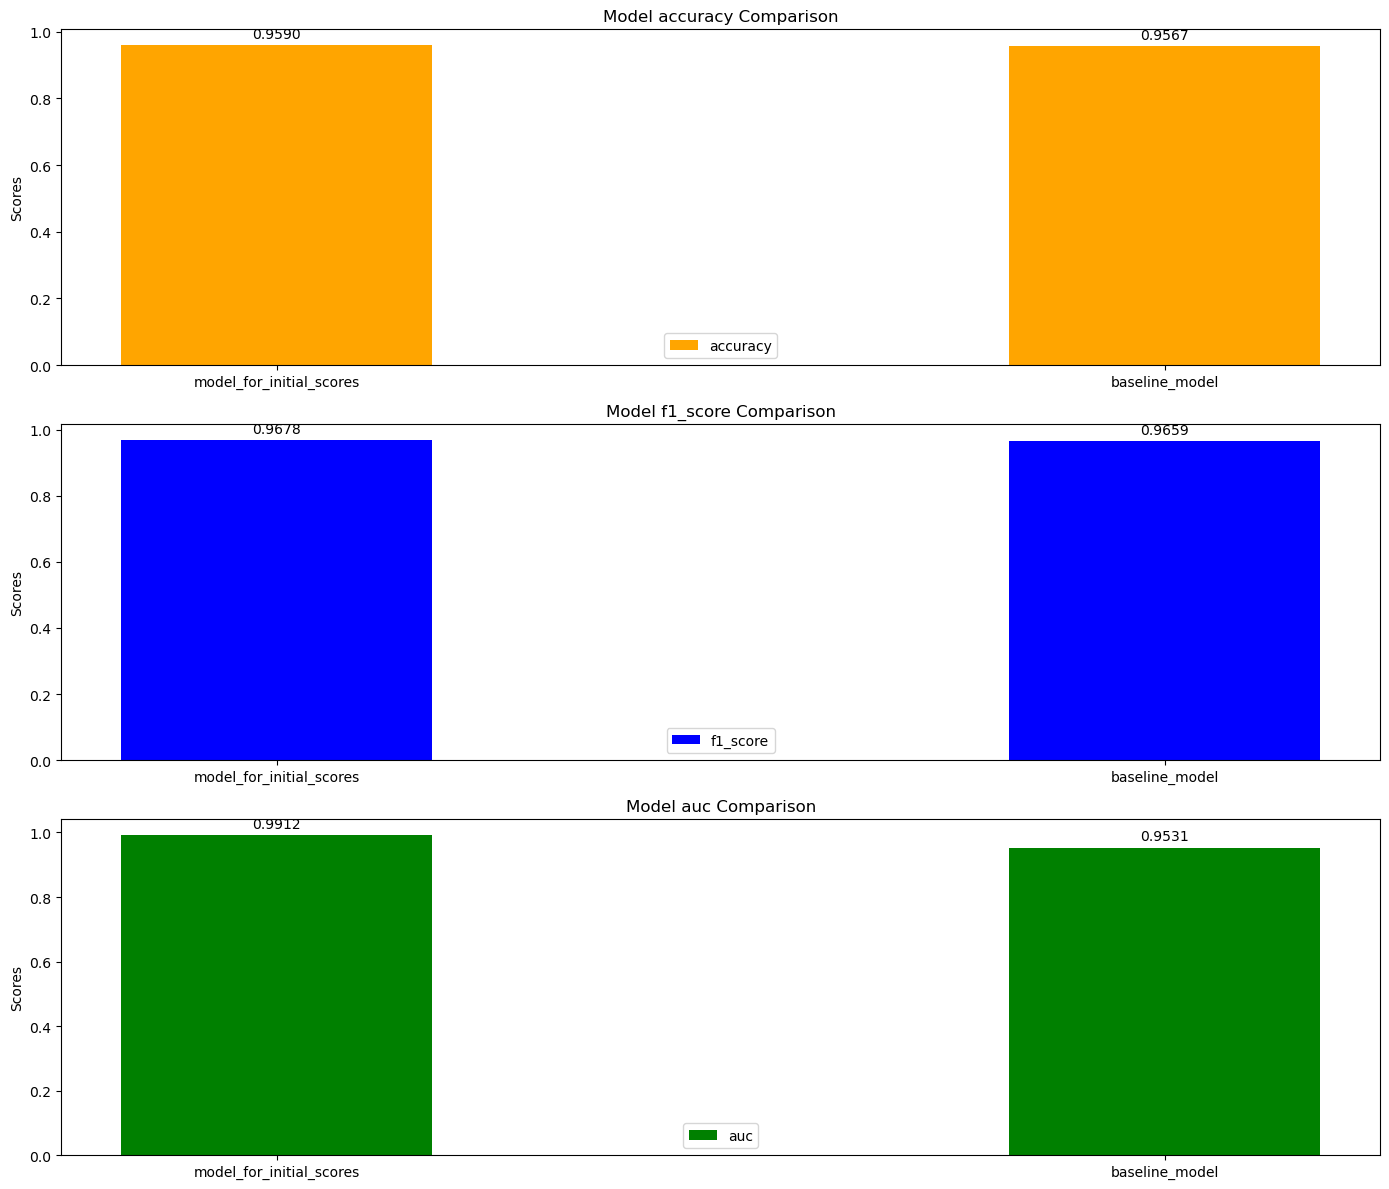

In [168]:
feature_strategy_vector = {
    "cibil_score": {"reliability": 0.005, "sign": 1},
}
threshold = 0.5
range_strategists_act = (0.0, threshold)

strategists_ds = strategy_vector_simulation(
    loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=True,
    threshold=threshold,
)

We can see that the strategists merely harmed the model, now we will explain why.

Let's see the original ds before strategists act, look at the cibil_score:


In [169]:
loan_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


And the strategists cibil_score:


In [170]:
strategists_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778.000000,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,1036.822553,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,1108.896560,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,1076.373888,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,1025.786709,12400000,8200000,29400000,5000000,0


We can see that the first user with 778 cibil score didnt changed, and the others that was <= 506 got a huge boost (because we chose really low reliability so strategists make aggressive strategies), so probably the model "flipped" its threshold, and moved it a little bit, so that high cibil score will not get a loan, as it's suspicious.


# Experiment - strategists harm model successfully:


Training model_for_initial_scores: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '944.3127093671171' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += (
Training baseline_model: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


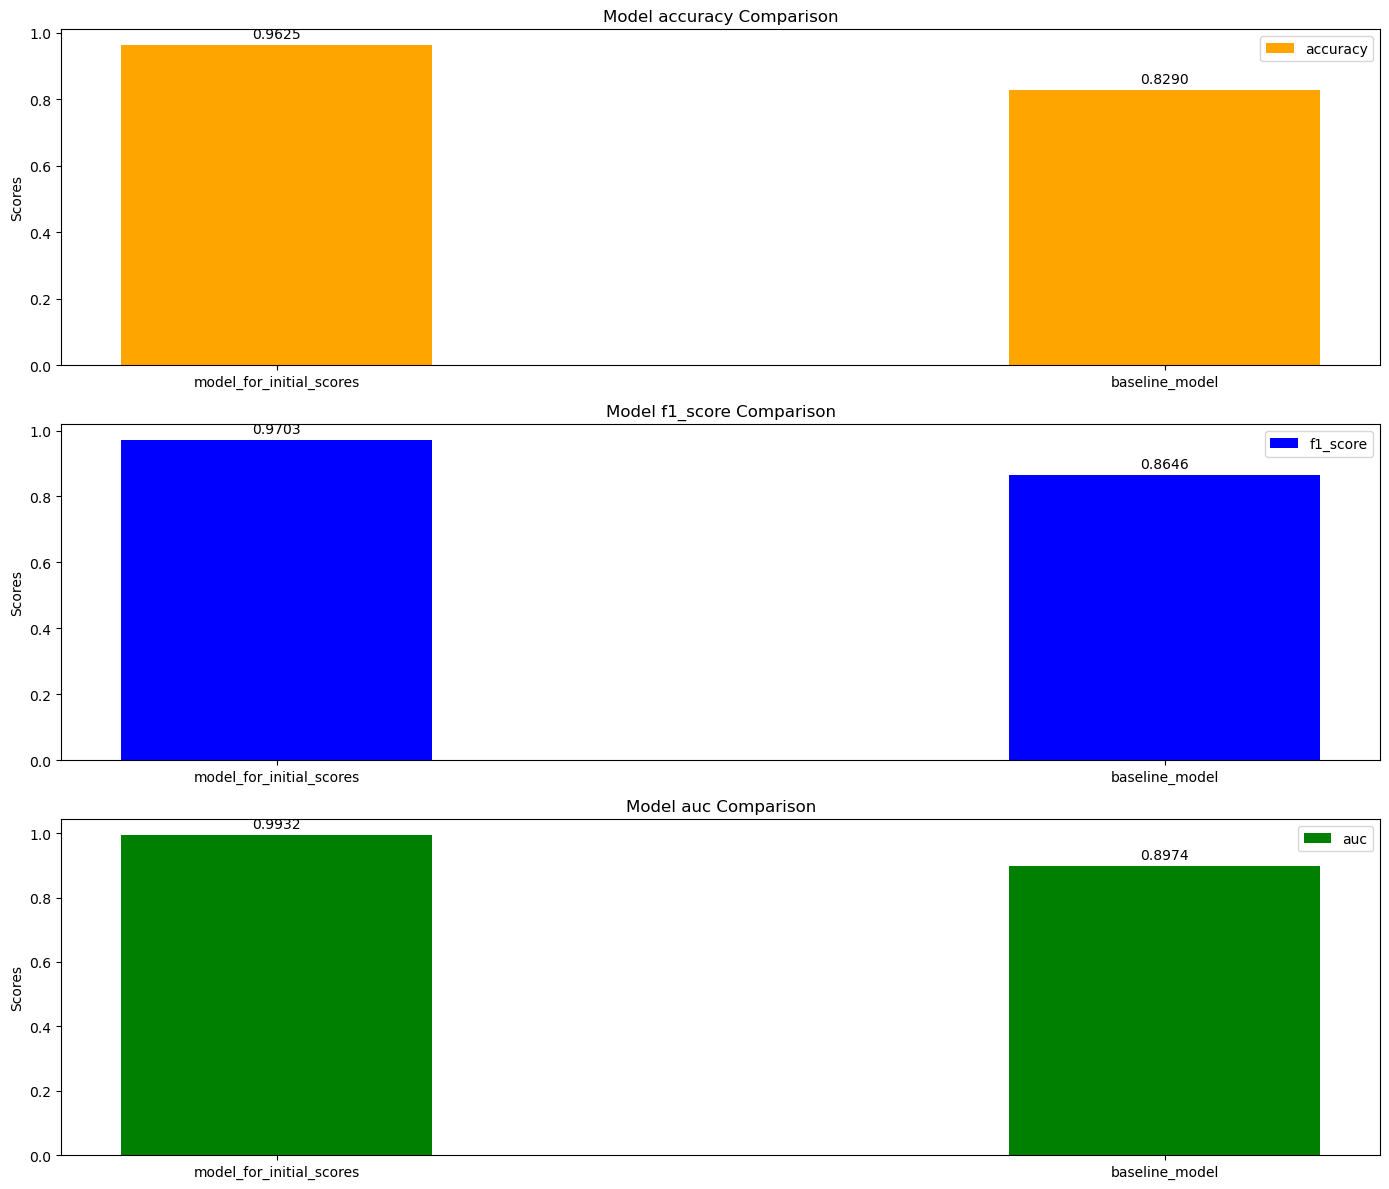

In [171]:
feature_strategy_vector = {
    "cibil_score": {"reliability": 0.2, "sign": 1},
}
strategists_ds = strategy_vector_simulation(
    loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=True,
    threshold=threshold,
)

Let's look again on the datasets:


In [172]:
loan_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [173]:
strategists_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778.000000,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,944.312709,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,1027.007055,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,975.133441,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,891.074393,12400000,8200000,29400000,5000000,0


As we can see, the baseline model that train on dataset after strategists act - got 0.79 acc, and the first model got 0.95 acc.

The reason is, as we see in the heads of the dataset, choosing reliability = 0.2 to cibil_score caused the people who did not got a loan to have cibil_score that is not too much high (as the strategists failed in previous experiment), but exactly enter the area of the non-strategists that got a loan, so they deceived the model.


# Strategies in Non-important features can act against strategists Experiment:


Hypothesis: If users will also use strategies in the non-important features (right now they are all not important except for cibil_score) - the model can overcome the strategies in the important features by identifying the strategies in the non-important features and lower their scores.


We will put as the previous experiment - cibil_score reliability = 0.2.

In the previous experiment it harmed the model a lot (0.79 acc), but no we will also put reliability (meaning, strategists) on non-important features, and we will see if the model can now improve:


Training model_for_initial_scores:   0%|          | 0/100 [00:00<?, ?it/s]

Training model_for_initial_scores: 100%|██████████| 100/100 [00:06<00:00, 15.47it/s]
/tmp/ipykernel_105940/964990008.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, "using_strategy"] = bool(False)
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '941.9985968108089' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += (
/tmp/ipykernel_105940/964990008.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21043447.015494674' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_d

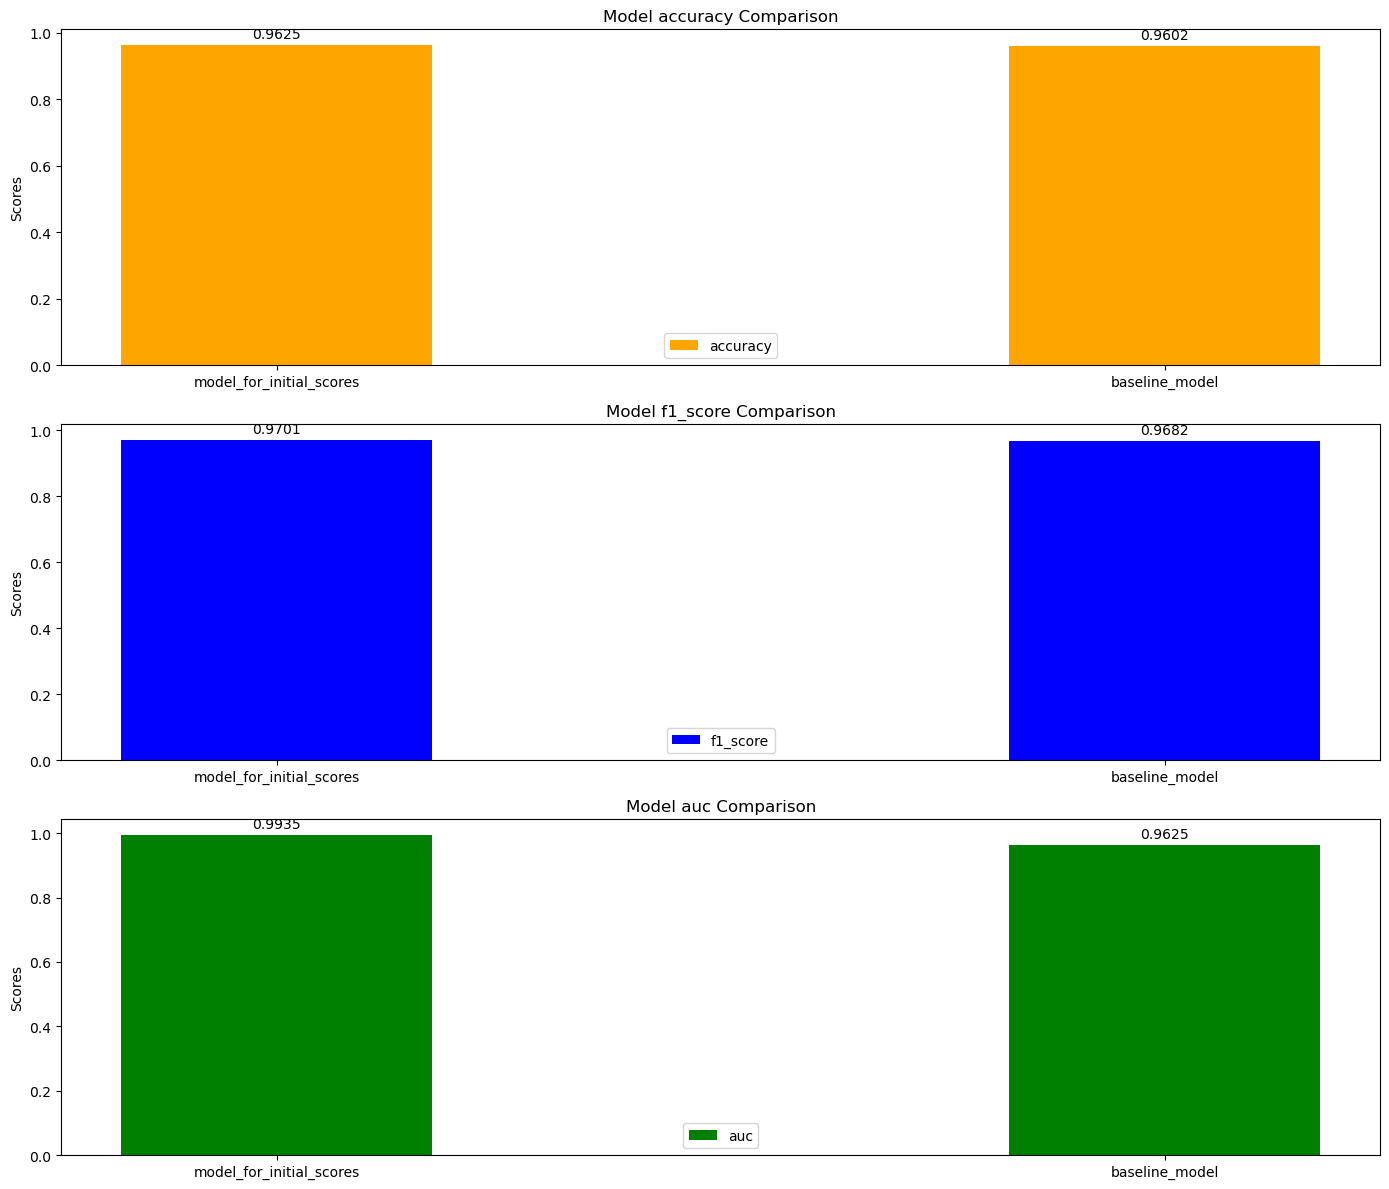

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9.600000e+06,2.990000e+07,12.000000,778.000000,2.400000e+06,17600000,22700000,8000000,1
1,0,0,1,2.007182e+05,2.104345e+07,-1.294889,941.998597,8.509973e+06,2200000,8800000,3300000,0
2,3,1,0,5.104551e+06,3.849912e+07,10.402493,995.122848,1.287211e+07,4500000,33300000,12800000,0
3,3,1,0,4.630803e+06,3.972955e+07,-1.405775,963.823339,2.348194e+07,3300000,23300000,7900000,0
4,5,0,1,6.253806e+06,3.307713e+07,10.383398,918.462587,1.788111e+07,8200000,29400000,5000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4264,5,1,1,-2.636622e+06,1.057579e+07,2.789996,830.988196,8.608161e+06,500000,3300000,800000,0
4265,0,0,1,3.300000e+06,1.130000e+07,20.000000,559.000000,4.200000e+06,2900000,11000000,1900000,1
4266,2,0,0,2.517037e+06,3.178878e+07,9.107537,945.199682,6.998353e+06,12400000,18100000,7300000,0
4267,1,0,0,4.100000e+06,1.280000e+07,8.000000,780.000000,8.200000e+06,700000,14100000,5800000,1


In [174]:
feature_strategy_vector = {
    "cibil_score": {"reliability": 0.2, "sign": 1},
    "loan_amount": {"reliability": 0.5, "sign": 1},
    "income_annum": {"reliability": 0.3, "sign": -1},
    "loan_term": {"reliability": 0.2, "sign": -1},
    "residential_assets_value": {"reliability": 0.3, "sign": 1},
}
strategy_vector_simulation(
    loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=True,
    threshold=threshold,
)

As we can see, we imporved the model from 0.79 acc to 0.95 acc only by adding strategists!

Conclusion: banks can detect strategic users, even in features that the bank's model not use (for example - how many Savings funds the user created last year), to improve the performance.

If the bank was using here only cibil_score - it whould get ~0.79 acc, but it looked on the non-important features and improved by identifying the strategists.


# Make other features informative:


In order for implement our algos, we must at least 2 informative features.

Let's change loan_ds a bit so we will have more informative features,
we wil make there informative:

- "loan_amount"
- "income_annum"
- "luxury_assets_value"
- "cibil_score" (was informative, we will make it as informative as the others, meaning, same acc if train on 1 feature only)


In [175]:
informative_loan_ds = loan_ds.copy()
informative_features = [
    "loan_amount",
    "income_annum",
    "luxury_assets_value",
    "cibil_score",
]

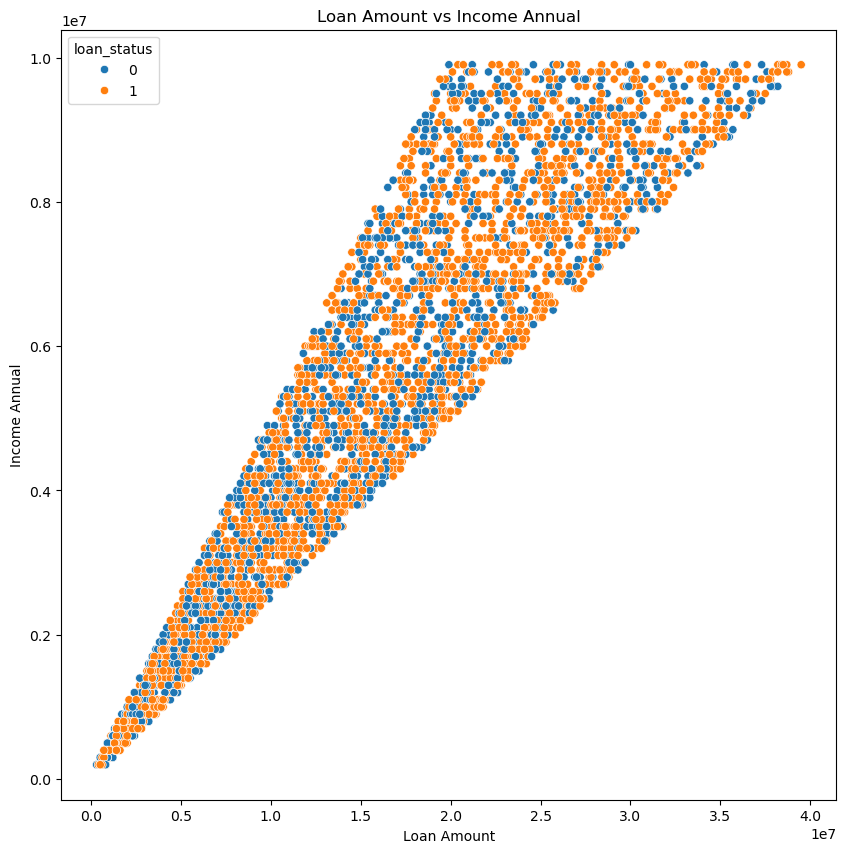

In [176]:
# plot loan_amount and income_annum, and color will be the loan_status

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=informative_loan_ds["loan_amount"],
    y=informative_loan_ds["income_annum"],
    hue=informative_loan_ds["loan_status"],
)
plt.title("Loan Amount vs Income Annual")
plt.xlabel("Loan Amount")
plt.ylabel("Income Annual")
plt.show()

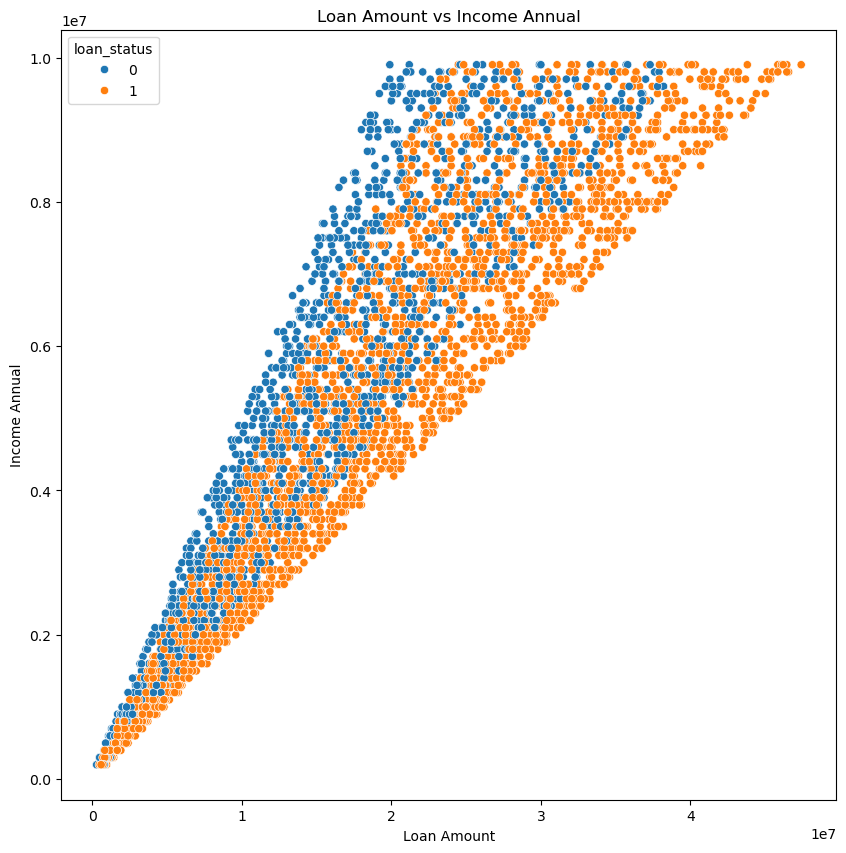

In [177]:
# in the informative ds we want higher loan amount for the loan_status=1 users,
# so multiply by factor
factor = 1.3
informative_loan_ds["loan_amount"] = informative_loan_ds.apply(
    lambda x: x["loan_amount"] *
    1.2 if x["loan_status"] == 1 else x["loan_amount"],
    axis=1,
)


# plot again:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=informative_loan_ds["loan_amount"],
    y=informative_loan_ds["income_annum"],
    hue=informative_loan_ds["loan_status"],
)
plt.title("Loan Amount vs Income Annual")
plt.xlabel("Loan Amount")
plt.ylabel("Income Annual")
plt.show()

In [178]:
def ds_copy_with_chosen_features(ds, features_cols):
    """
    Returns a copy of the dataset with only the chosen features and loan_status columns.
    """
    return ds[features_cols + ["loan_status"]].copy()


def train_on_chosen_features(ds, model, features_cols, threshold=0.5):
    ds_with_chosen_features = ds_copy_with_chosen_features(ds, features_cols)
    _, _, train_loader, test_loader = prepare_data(ds_with_chosen_features)
    model_results = train_and_evaluate_pytorch_model(
        threshold, model, "model", train_loader, test_loader
    )
    return model_results

In [179]:
# train on the informative_loan_ds on loan_amount only
features_cols = ["loan_amount"]
model = get_large_mlp_model(len(features_cols))
threshold = 0.5
model_results = train_on_chosen_features(
    informative_loan_ds, model, features_cols, threshold=threshold
)
print(
    f"Model trained on {features_cols} features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model:   0%|          | 0/100 [00:00<?, ?it/s]

Training model: 100%|██████████| 100/100 [00:06<00:00, 15.72it/s]

Model trained on ['loan_amount'] features has acc: 0.63



/home/priel/anaconda3/envs/Nov2023py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/priel/anaconda3/envs/Nov2023py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/priel/anaconda3/envs/Nov2023py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

0.63 is an okay acc, let's make other features to have about the same acc.


In [180]:
# now mul income_annum by factor for loan_status=1 users:

factor = 0.9  # reduce cause negative gradient. So that people with lower income have
# higher chance of getting loan
informative_loan_ds["income_annum"] = informative_loan_ds.apply(
    lambda x: (
        x["income_annum"] * factor if x["loan_status"] == 1 else x["income_annum"]
    ),
    axis=1,
)

# train on the informative_loan_ds on loan_amount only
features_cols = ["income_annum"]
model = get_large_mlp_model(len(features_cols))
threshold = 0.5
model_results = train_on_chosen_features(
    informative_loan_ds, model, features_cols, threshold=threshold
)
print(
    f"Model trained on {features_cols} features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]

Model trained on ['income_annum'] features has acc: 0.67


In [181]:
# luxury_assets_value
factor = 1.4
informative_loan_ds["luxury_assets_value"] = informative_loan_ds.apply(
    lambda x: (
        x["luxury_assets_value"] * factor
        if x["loan_status"] == 1
        else x["luxury_assets_value"]
    ),
    axis=1,
)

# train on the informative_loan_ds on loan_amount only
features_cols = ["luxury_assets_value"]
model = get_large_mlp_model(len(features_cols))
threshold = 0.5
model_results = train_on_chosen_features(
    informative_loan_ds, model, features_cols, threshold=threshold
)
print(
    f"Model trained on {features_cols} features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model:   0%|          | 0/100 [00:00<?, ?it/s]

Training model: 100%|██████████| 100/100 [00:06<00:00, 14.79it/s]

Model trained on ['luxury_assets_value'] features has acc: 0.63



/home/priel/anaconda3/envs/Nov2023py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/priel/anaconda3/envs/Nov2023py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/priel/anaconda3/envs/Nov2023py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Let's make cibil_score informative in the same magnitude


In [182]:
# mul cibil_score by factor for loan_status=1 users:
factor = 0.6
informative_loan_ds["cibil_score"] = informative_loan_ds.apply(
    lambda x: x["cibil_score"] * factor if x["loan_status"] == 1 else x["cibil_score"],
    axis=1,
)

# train on the informative_loan_ds on cibil_score only
features_cols = ["cibil_score"]
model = get_large_mlp_model(len(features_cols))
threshold = 0.5
model_results = train_on_chosen_features(
    informative_loan_ds, model, features_cols, threshold=threshold
)
print(
    f"Model trained on {features_cols} features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model: 100%|██████████| 100/100 [00:06<00:00, 14.93it/s]

Model trained on ['cibil_score'] features has acc: 0.68


In [183]:
# train on all features
_, _, train_loader, test_loader = prepare_data(informative_loan_ds)
model = get_large_mlp_model(input_size)
threshold = 0.5
model_results = train_and_evaluate_pytorch_model(
    threshold, model, "model", train_loader, test_loader
)
print(
    f"Model trained on all features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model:  16%|█▌        | 16/100 [00:01<00:05, 15.42it/s]

Now our informative model indeed need to use several features to get 0.88 acc,
cause when using each of the 4 alone it gets ~0.64 acc.


# Features reliabilities informed models


In this section, we will present algorithms that utilize the strategic vector to make the informed model better.


Our algos:

- let's drop from strategic ds the top k most non reliable features and train on it them only.

- Train k models, the ith model will drop the ith most non-reliable (high strategic magnitude) feature.

  Then define an aggregator model that will take the outputs of all models and
  will do this:

  the prob it will predict will be:
  weighted sum, such that the ith model predict probability $p_i$,
  and this prob is weighted with the strategic magnitude of the ith feature it dropped.

  The idea is that as it dropped a high strategically feature(less reliable) we want to give the model more weight because it dropped a high noised feature.

  then divide all by the sum of all top k features strategic magnitudes so that the prediction will be between 0 and 1.

- Algo we will not implement: Somehow lower the MLP connections of features in the first linear layer, in proportion to their strategy magnitude.


In [ ]:
# TODO here make a lot of experiments using the function that runs simulation